# Model Training

## Importing

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import InverseTimeDecay
from model.models import Model_1, Model_2, Model_3
from dataloader import DataLoader, DataLoader2
from model.losses import FocalLoss, WBCE, WCCE
from model.callbacks import UpdateAccuracy
from ops import reconstruct_image, recall_precision, compute_mAP
import os
import json
import shutil
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import average_precision_score

## Parameters

In [3]:
# load the params-patches.json options
with open(os.path.join('v1', 'params-patches.json')) as param_file:
    params_patches = json.load(param_file)

# load the params-patches.json options
with open(os.path.join('v1', 'params-training.json')) as param_file:
    params_training = json.load(param_file)
    
#load the params-model.json options
with open(os.path.join('v1', 'params-model.json')) as param_file:
    params_model = json.load(param_file)

#load the shapes.json options
with open('shapes.json') as param_file:
    shapes_json = json.load(param_file)

In [4]:
patches_path = params_patches['patches_path']

train_path = os.path.join(patches_path, params_patches['train_sub'])
val_path = os.path.join(patches_path, params_patches['val_sub'])
test_path = os.path.join(patches_path, params_patches['test_sub'])
full_path = params_patches['full_path']

img_path = params_patches['img_path']
data_raw = os.path.join(img_path, params_patches['data_sub']) 
label_raw = os.path.join(img_path, params_patches['label_sub'])

pred_path = params_patches['pred_path']

## Setting Dataloaders

In [5]:
dl_train = DataLoader2(
    batch_size = params_training['batch_size'],
    data_path=os.path.join(train_path, params_patches['data_sub']),
    label_path=os.path.join(train_path, params_patches['label_sub']),
    patch_size=128,
    opt_bands=8,
    sar_bands=4,
    num_classes=3,
    shuffle=True, 
    limit=params_training['patch_limit']
)

dl_val = DataLoader2(
    batch_size=params_training['batch_size'],
    data_path=os.path.join(val_path, params_patches['data_sub']),
    label_path=os.path.join(val_path, params_patches['label_sub']),
    patch_size=128,
    opt_bands=8,
    sar_bands=4,
    num_classes=3,
    limit=params_training['patch_limit']
)

## Model definition

In [6]:
n_classes = 3
filters = [32, 64, 128]

model = Model_3(filters, n_classes, name='modelo_1')

metrics = {
}

weights = [0.2, 0.8, 0.0]

learning_rate = InverseTimeDecay(
    initial_learning_rate=1e-3, 
    decay_steps=params_training['learning_reduction']*len(dl_train),
    decay_rate = 0.01,
    staircase=True
    )

optimizers = {
    'opt': tf.keras.optimizers.Adam(learning_rate = learning_rate),
    'sar': tf.keras.optimizers.Adam(learning_rate = learning_rate),
    'fusion': tf.keras.optimizers.Adam(learning_rate = learning_rate),
}

class_indexes = [0, 1]

model.compile(
    optimizers = optimizers,
    loss_fn = WBCE,
    metrics_dict = metrics,
    class_weights = weights,
    class_indexes = class_indexes,
    run_eagerly=params_training['run_eagerly']
)

In [7]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_opt_loss',
        patience = params_training['patience'],
        mode = 'min',
        restore_best_weights=True)
]


history = model.fit(
    x=dl_train,
    validation_data=dl_val,
    epochs=params_training['epochs_train'],
    callbacks=callbacks,
    verbose = 1
    )

Epoch 1/200
188/188 [==============================] - 9s 40ms/step - opt_loss: 0.1370 - opt_accuracy: 0.7328 - opt_f1score: 0.3760 - val_opt_loss: 0.0936 - val_opt_accuracy: 0.8074 - val_opt_f1score: 0.5407
Epoch 2/200
188/188 [==============================] - 6s 32ms/step - opt_loss: 0.1228 - opt_accuracy: 0.7649 - opt_f1score: 0.5441 - val_opt_loss: 0.0833 - val_opt_accuracy: 0.8440 - val_opt_f1score: 0.5746
Epoch 3/200
188/188 [==============================] - 6s 32ms/step - opt_loss: 0.1153 - opt_accuracy: 0.7778 - opt_f1score: 0.5932 - val_opt_loss: 0.0817 - val_opt_accuracy: 0.8412 - val_opt_f1score: 0.5494
Epoch 4/200
188/188 [==============================] - 6s 33ms/step - opt_loss: 0.1116 - opt_accuracy: 0.7836 - opt_f1score: 0.6038 - val_opt_loss: 0.0852 - val_opt_accuracy: 0.8501 - val_opt_f1score: 0.6119
Epoch 5/200
188/188 [==============================] - 6s 33ms/step - opt_loss: 0.1103 - opt_accuracy: 0.7893 - opt_f1score: 0.6157 - val_opt_loss: 0.0877 - val_opt_acc

## Show training history

## Save weights

In [8]:
model.save_weights('weights.h5')

### Load images

In [9]:
opt = np.load(os.path.join(data_raw, 'opt.npy'))
#sar = np.load(os.path.join(data_raw, 'sar.npy'))

In [10]:
pred = model.predict_from_patches(
    opt, 
    params_patches['patch_size'], 
    params_patches['patch_stride'], 
    16)

100%|██████████| 9990/9990 [01:57<00:00, 85.00it/s]


In [11]:
labels = np.load(os.path.join(label_raw, 'labels.npy'))

C:\Users\FELFER~1\AppData\Local\Temp/ipykernel_9768/1642766977.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


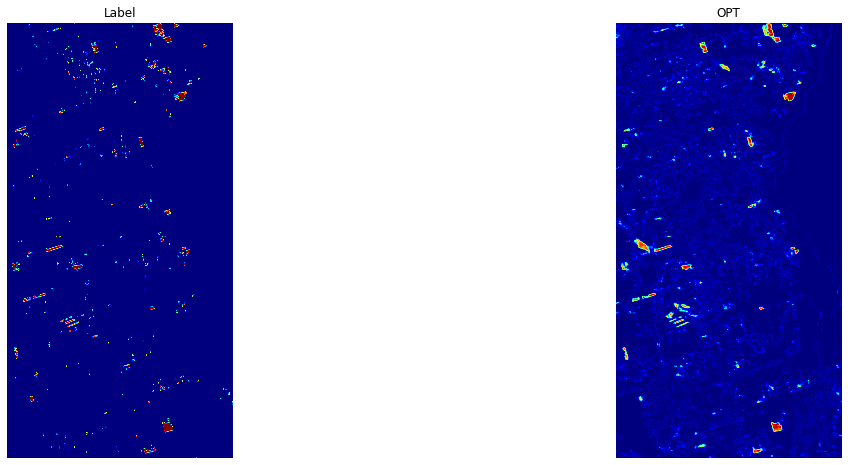

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (20,8))


img = Image.fromarray(np.uint8(to_categorical(labels, 3)[:,:,1]*255))
ax[0].axis('off')
ax[0].set_title(f'Label')
ax[0].imshow(img, cmap = 'jet')

img = Image.fromarray(np.squeeze(np.uint8(pred*255)))
ax[1].axis('off')
ax[1].set_title(f'OPT')
ax[1].imshow(img, cmap = 'jet')

fig.show()

In [13]:
shutil.rmtree(pred_path, ignore_errors=True)
os.makedirs(pred_path)

In [14]:
np.save(os.path.join(pred_path, 'opt.npy'), np.squeeze(pred[0]))

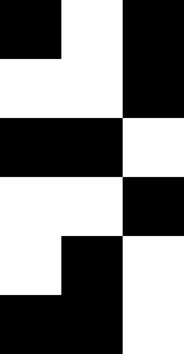

In [15]:
test_mask = np.squeeze(np.zeros_like(pred))
test_tiles = params_patches['test_tiles']
split_v = params_patches['tiles_v']
split_h = params_patches['tiles_h']
lines = np.array_split(range(pred.shape[0]), split_v)
cols = np.array_split(range(pred.shape[1]), split_h)
i = 0
dic = {}
for line in lines:
    for col in cols:
        i+=1
        if i not in test_tiles:
            continue
        test_mask[line[0]:line[-1]+1, col[0]:col[-1]+1] = 1
img = Image.fromarray(np.uint8(test_mask*255))
resize = 0.02
shape = (int(resize*test_mask.shape[1]), int(resize*test_mask.shape[0]))
img = img.resize(shape)
img

In [17]:
rec_prec_l = []
map_l = []

ref1 = np.ones_like(labels).astype(np.float32)

ref1 [labels == 2] = 0
TileMask = test_mask * ref1
GTTruePositives = labels==1

Npoints = 10
Pmax = np.max(pred[GTTruePositives * TileMask ==1])
Pmin = np.min(pred[GTTruePositives * TileMask ==1])
ProbList = np.linspace(Pmax,0,Npoints) 

rec_pre_metrics = recall_precision(labels, np.squeeze(pred), 625, ProbList,  test_mask)
rec_prec_l.append(rec_pre_metrics)

Recall = rec_pre_metrics[:,0]
Precision = rec_pre_metrics[:,1]

mAP = compute_mAP(Recall, Precision)
map_l.append(mAP)
print(f'mAP({i}): ', mAP)
    
    

100%|██████████| 10/10 [21:10<00:00, 127.06s/it]

mAP(18):  59.580722761802754


No handles with labels found to put in legend.


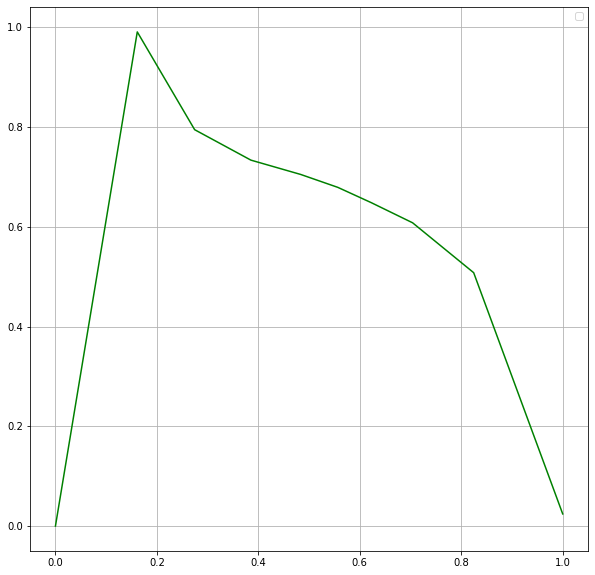

In [19]:
plt.figure(figsize = (10,10))

plt.plot(rec_prec_l[0][:,0], rec_prec_l[0][:,1], 'g-')


plt.legend(loc='upper right')
plt.grid()
plt.show()